### Notebook for annotating the 6mpi cardiac MoMacs using `GPT-4`

#### Environment: Scanpy

- **Developed by**: Alexandra Cirnu
- **Modified by**: Alexandra Cirnu
- **Talavera-López Lab - Würzburg Institute for Systems Immunology - Faculty of Medicine - Julius Maximilian Universität Würzburg**
- **Created on**: 240324
- **Last modified**: 240326

##### Load required modules

In [ ]:
import anndata
import logging
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sb
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib import rcParams
from scipy.sparse import csr_matrix
import muon as mu
from muon import atac as ac
from muon import prot as pt

In [ ]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()

sc.settings.set_figure_params(dpi=100)
%matplotlib inline

In [ ]:
def X_is_raw(adata):
    return np.array_equal(adata.X.sum(axis=0).astype(int), adata.X.sum(axis=0))

##### Load in dataset that was clustered with `leiden`

In [ ]:
input = '/home/acirnu/data/ACM_cardiac_leuco/5_Leiden_clustering_and_annotation/ACM_myeloids_leiden_clustering_muon_ac240502.raw.h5mu'
mdata = mu.read_h5mu(input)
mdata

In [ ]:
adata = mdata.mod["rna"]
adata

In [ ]:
X_is_raw(adata)  

In [ ]:
adata.obs

In [ ]:
X_data = adata.X.copy()
X_data_sparse = csr_matrix(X_data)
X_data_df = pd.DataFrame.sparse.from_spmatrix(X_data_sparse, index=adata.obs.index, columns=adata.var.index)
print("Shape of counts DataFrame:", X_data_df.shape)
print(X_data_df)

In [ ]:
adata_raw = adata.copy()

#### Normalize and logarithmize data 

In [ ]:
sc.pp.normalize_total(adata, target_sum = 1e6, exclude_highly_expressed = True)
sc.pp.log1p(adata)

In [ ]:
X_data = adata.X.copy()
X_data_sparse = csr_matrix(X_data)
X_data_df = pd.DataFrame.sparse.from_spmatrix(X_data_sparse, index=adata.obs.index, columns=adata.var.index)
print("Shape of counts DataFrame:", X_data_df.shape)
print(X_data_df)

### Clustering the neighborhood graph

In [ ]:
sc.pl.umap(adata, color=["C_scANVI", "Ccr2", "Trem2"], color_map='RdPu')

### Finding marker genes

In [ ]:
sc.settings.verbosity = 2

In [ ]:
sc.tl.rank_genes_groups(adata, "C_scANVI", method="wilcoxon", n_genes= 100)
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

In [ ]:
#Show the top 10 ranked genes per cluster
pd.DataFrame(adata.uns["rank_genes_groups"]["names"]).head(10).T    

In [ ]:
['Stmn1','Mki67','Top2a','Tubb5','Hmgb2',
 'Malat1','Pid1','Slc9a9','Dennd1a','Ptprj',
 'Pf4','C1qa','C1qc','C1qb','Cd81',
 'Hdc','Pde4d','Cpa3','Fcer1a','Gata2',
 'Ccr2','Rplp0','Cd74','Cd52','Rps27a',
 'Ninj1','Ftl1','Ctsb','Mt1','Grn',
 'Il1r2','Csf3r','S100a9','Sorl1','Clec4d']

In [ ]:
# Initialize an empty list to store arrays for vertical stacking
out = []
result = adata.uns["rank_genes_groups"]
groups = result["names"].dtype.names

# Iterate over each group
for group in groups:
    # Stack arrays vertically and append to the 'out' list
    out.append(np.vstack((
        result['names'][group],
        result['scores'][group],
        result['pvals_adj'][group],
        result['logfoldchanges'][group],
        np.array([group] * len(result['names'][group])).astype('object')
    )).T)

# Vertically stack all arrays in the 'out' list
out = np.vstack(out)

#Create a data frame
markers = pd.DataFrame(out, columns= ['Gene', 'Score', 'Adj_pvalue', 'Logfoldchange', 'Cluster'])

markers.shape

In [ ]:
markers_filtered = markers[(markers.Adj_pvalue < 0.05) & (abs(markers.Logfoldchange) > 1)]
markers_filtered.shape

Write a .csv table for the filtered markers 

In [ ]:
#To see the marker genes for each cluster vary the number in markers_filtered.Cluster

markers_0 = markers_filtered[markers_filtered.Cluster == 'DC']
markers_0.head(10)

### Prompt the top genes for each cluster to `GPT-4` (whole .csv file)

**User**
1. Identify the immune cell type subpopulations of murine heart cells using the markers in the 'Gene' column of the uploaded csv file and assign it to each cluster from the 'Cluster' column. Only provide the cell type name. Some can be a mixture of multiple cell types. Consider that the cells can be only myeloid cells. 
2. Can you be more specific on the clusters you were able to assign? For example can you identify tissue-resident macrophages or pro-inflammatory monocytes?
3. Can you also define other subpopulations?

**ChatGPT**

- Cluster 0: Macrophages, Tissue-Resident Macrophages
- Cluster 1: Monocytes
- Cluster 2: Macrophages, Tissue-Resident Macrophages
- Cluster 3: Undetermined
- Cluster 4: M1 Macrophages, Pro-Inflammatory Monocytes
- Cluster 5: M1 Macrophages, Pro-Inflammatory Monocytes
- Cluster 6: M1 Macrophages, Neutrophils
- Cluster 7: Undetermined
- Cluster 8: Dendritic Cells, Pro-Inflammatory Monocytes
- Cluster 9: Monocytes, Pro-Inflammatory Monocytes
- Cluster 10: Macrophages
- Clusters 11, 12, 13, 14, 15, 16, 17: Undetermined

- Markers for tissue-resident macrophages: Timd4, Vsig4, and Cd163
- Markers for pro-inflammatory macrophages: Nos2, Tnf, Il1b
- Markers for anti-inflammaotry macrophages: Arg1, Il10, Mrc1 (CD206)
- Markers for conventional DCs: Itgax (CD11c); cDC1 = H2-Aa (MHC II); cDC2 = Cd172a (SIRPa)
- Markers for pDCs: Siglech, Bst2, hich expr. of Il3ra (CD123)
- Markers for classical monocytes: high Ly6c expression
- Markers for non-classical monocytes: Cx3cr1, low Ly6c expression+
- Markers for pro-inflammatory monocytes: higher expression of Ccr2 and Ly6c2

### Visualize the top 3 markers for each cluster

In [ ]:
fig, ax = plt.subplots(figsize=(20, 8))
sc.pl.dotplot(adata, var_names=[    
                                    'Malat1','Pid1','Slc9a9','Dennd1a','Ptprj',
                                    'Hdc','Pde4d','Cpa3','Fcer1a','Gata2',
                                    'Il1r2','Csf3r','S100a9','Sorl1','Clec4d',
                                    'Pf4','C1qa','C1qc','C1qb','Cd81',
                                    'Ninj1','Ftl1','Ctsb','Mt1','Grn',
                                    'Stmn1','Mki67','Top2a','Tubb5','Hmgb2',
                                    'Ccr2','Rplp0','Cd74','Cd52','Rps27a'], groupby="C_scANVI", ax=ax, dendrogram = True, cmap= "magma")
plt.show()

In [ ]:
sc.pl.umap(adata, color= ['C_scANVI', 'Malat1','Pid1','Slc9a9','Dennd1a','Ptprj',
                                    'Hdc','Pde4d','Cpa3','Fcer1a','Gata2',
                                    'Il1r2','Csf3r','S100a9','Sorl1','Clec4d',
                                    'Pf4','C1qa','C1qc','C1qb','Cd81',
                                    'Ninj1','Ftl1','Ctsb','Mt1','Grn',
                                    'Stmn1','Mki67','Top2a','Tubb5','Hmgb2',
                                    'Ccr2','Rplp0','Cd74','Cd52','Rps27a', 'C_scANVI'], legend_loc="right margin", frameon=False, color_map="RdPu")

In [ ]:
sc.pl.umap(adata, color= ['leiden', 'C_scANVI', 'Timd4'], legend_loc="right margin", frameon=False, color_map="RdPu")

#### Add `leiden` information to the C_scANVI seed label

In [ ]:
adata.obs['classification'] = adata.obs['leiden'].copy()
adata.obs

/home/acirnu/miniforge3/envs/Scanpy/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))


KeyboardInterrupt: 

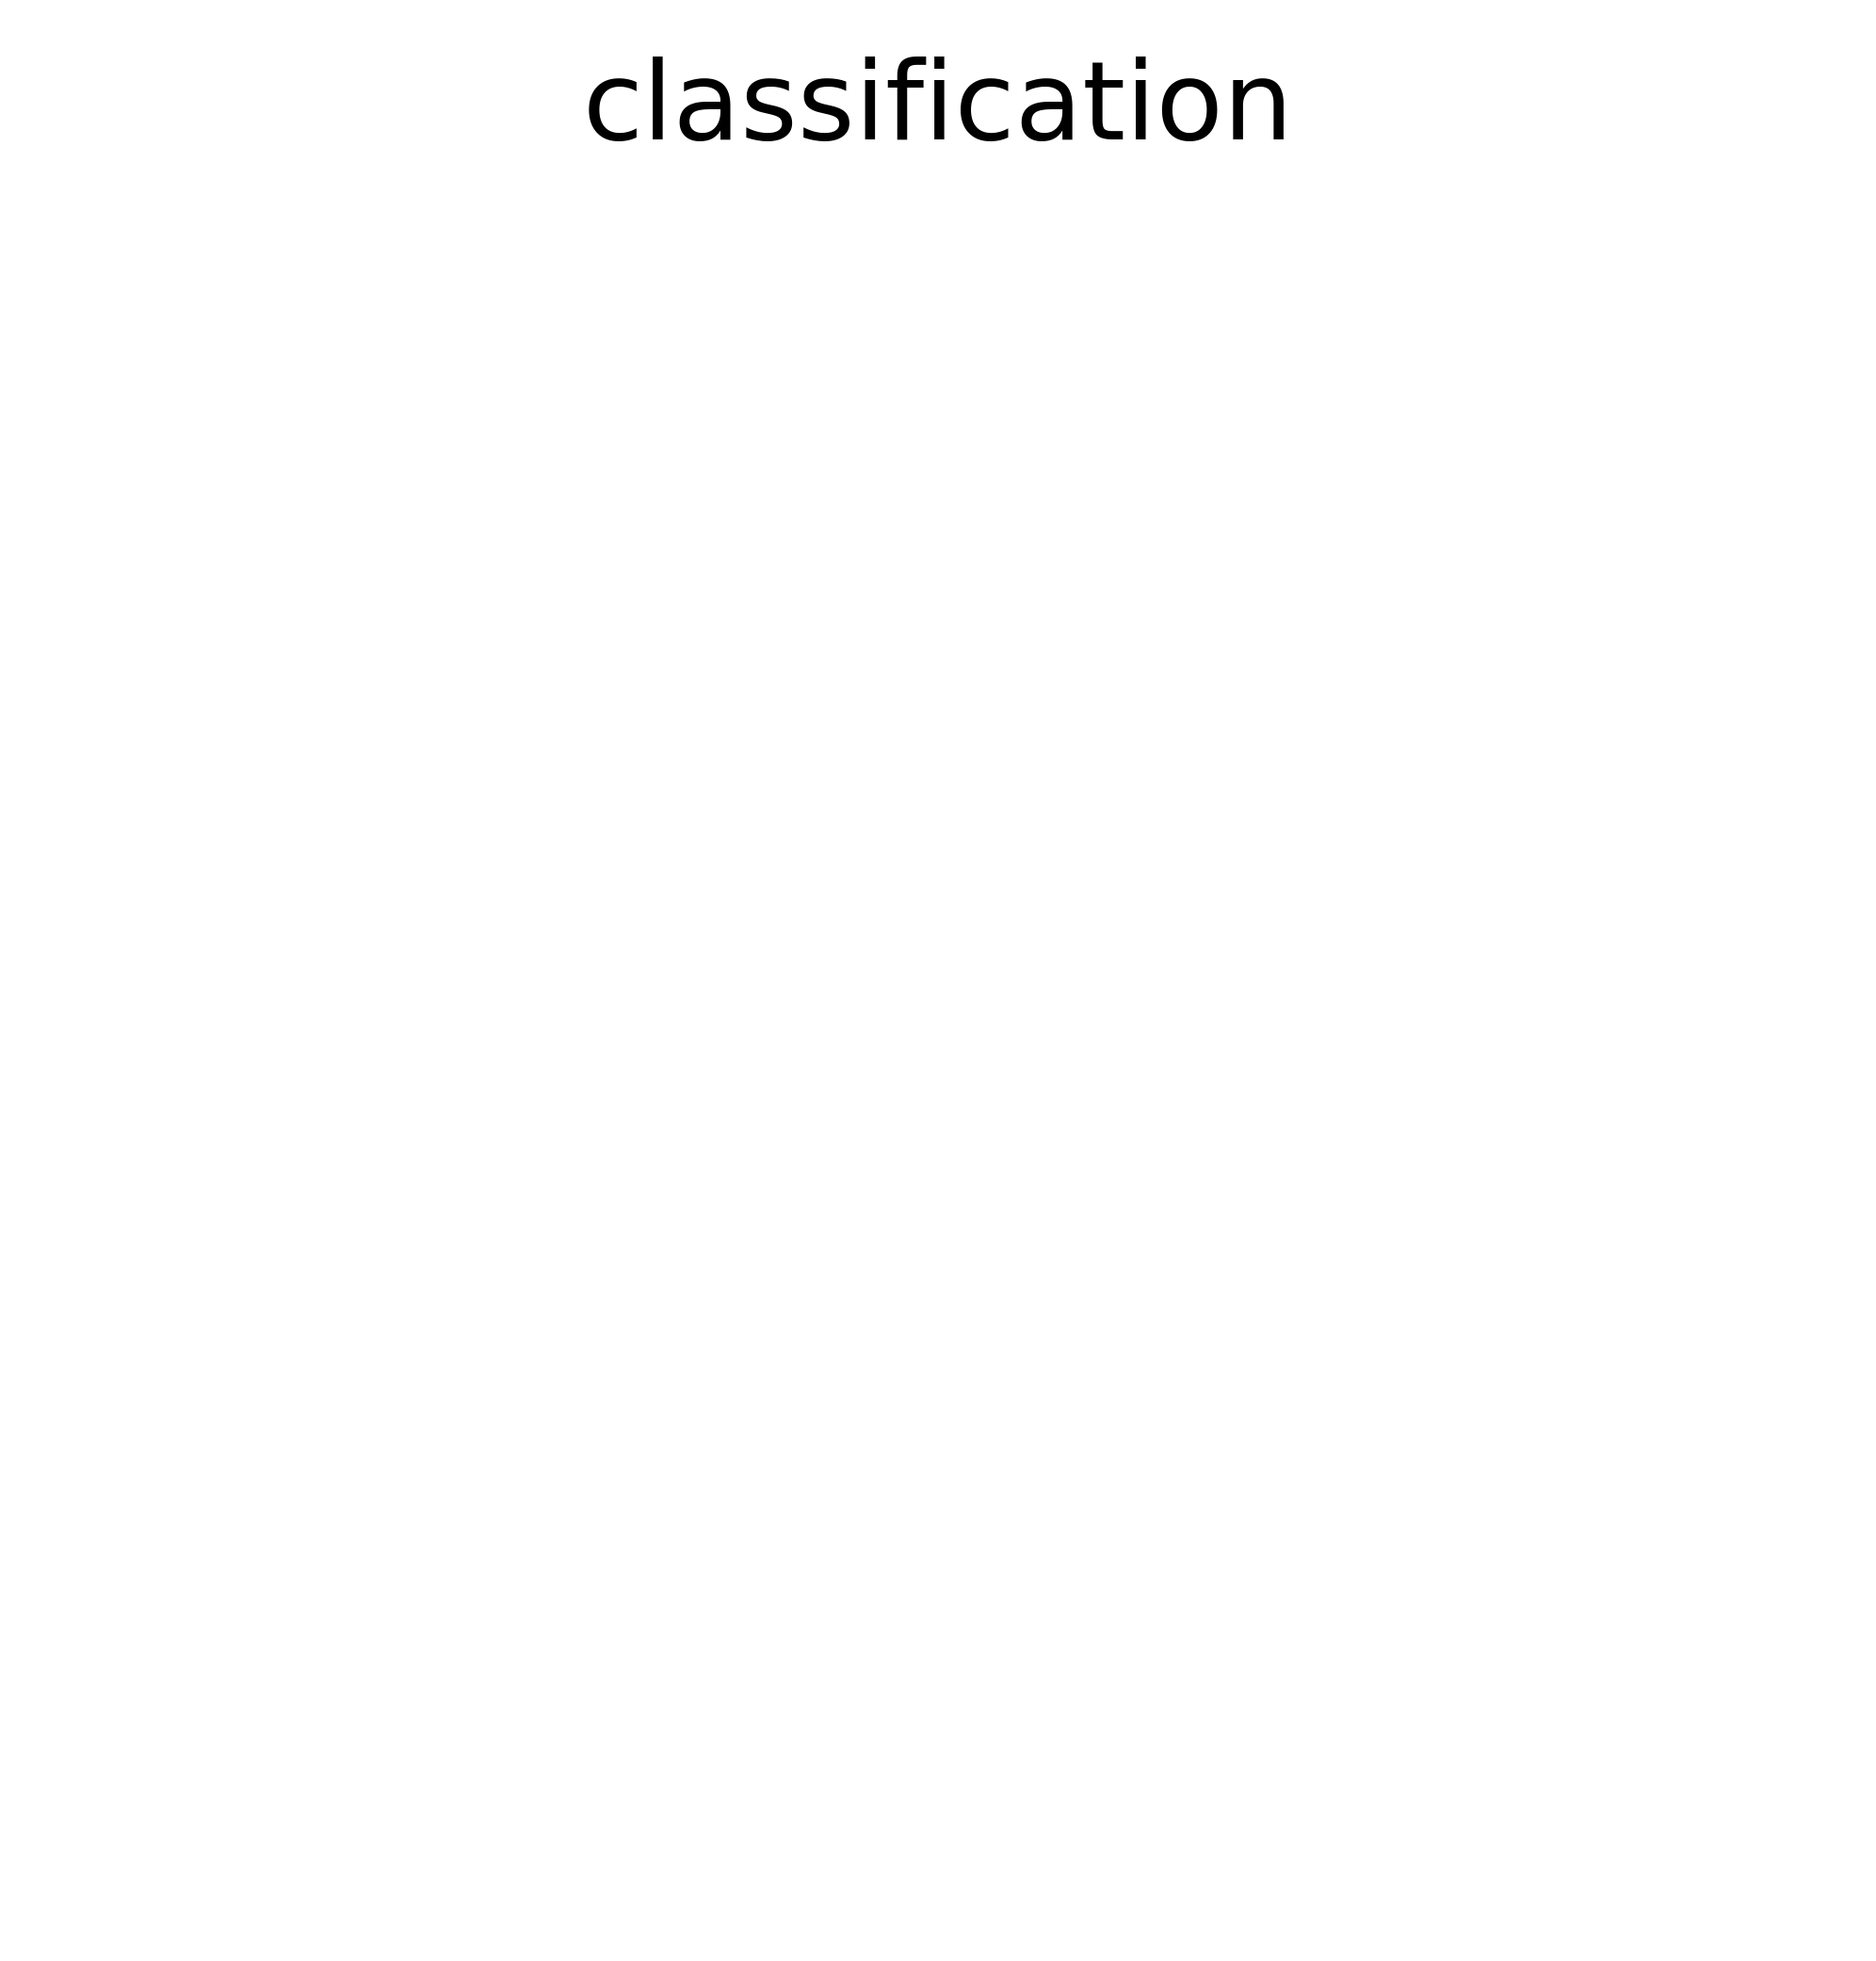

In [ ]:
sc.settings.set_figure_params(dpi=300)
sc.pl.umap(adata, color= ['classification'], legend_loc="right margin", legend_fontsize= 5 , frameon=False, color_map="RdPu", ncols=1)

In [ ]:
adata.obs["classification"].cat.categories

In [ ]:
highlight_DC = ['DC_0', 'DC_1', 'DC_2', 'DC_4', 'DC_5', 'DC_6', 'DC_7', 'DC_8', 'DC_9','DC_11', 'DC_12', 'DC_14', 'DC_16']
highlight_DOCK4MØ = ['DOCK4+MØ_0', 'DOCK4+MØ_1','DOCK4+MØ_2', 'DOCK4+MØ_3', 'DOCK4+MØ_4', 'DOCK4+MØ_5', 'DOCK4+MØ_6','DOCK4+MØ_7', 'DOCK4+MØ_8', 'DOCK4+MØ_9', 'DOCK4+MØ_10', 'DOCK4+MØ_11','DOCK4+MØ_12', 'DOCK4+MØ_15']
highlight_LYVE1MØ = ['LYVE1+MØ_0', 'LYVE1+MØ_1', 'LYVE1+MØ_2','LYVE1+MØ_3', 'LYVE1+MØ_4', 'LYVE1+MØ_5', 'LYVE1+MØ_6', 'LYVE1+MØ_7','LYVE1+MØ_8', 'LYVE1+MØ_9', 'LYVE1+MØ_10', 'LYVE1+MØ_11', 'LYVE1+MØ_12','LYVE1+MØ_16']
highlight_Mast = ['Mast_13', 'Mast_16']
highlight_Monocytes = ['Monocytes_0', 'Monocytes_1','Monocytes_2', 'Monocytes_3', 'Monocytes_4', 'Monocytes_5','Monocytes_6', 'Monocytes_7', 'Monocytes_8', 'Monocytes_9','Monocytes_10', 'Monocytes_11', 'Monocytes_12', 'Monocytes_13','Monocytes_15']
highlight_MØ_general = ['MØ_general_0', 'MØ_general_1', 'MØ_general_2','MØ_general_3', 'MØ_general_4', 'MØ_general_5', 'MØ_general_6','MØ_general_7', 'MØ_general_8', 'MØ_general_9', 'MØ_general_11','MØ_general_12', 'MØ_general_14', 'MØ_general_17']
highlight_Neutrophils = ['Neutrophils_0','Neutrophils_4', 'Neutrophils_6', 'Neutrophils_12'] 

In [ ]:
groups = [
    ('classification', highlight_DC),
    ('classification', highlight_DOCK4MØ),
    ('classification', highlight_LYVE1MØ),
    ('classification', highlight_Mast),
    ('classification', highlight_Monocytes),
    ('classification', highlight_MØ_general),
    ('classification', highlight_Neutrophils),
    ('C_scANVI', None)  # This one does not use 'groups' so we pass None
]

# Setup the subplot grid
fig, axs = plt.subplots(2, 4, figsize=(20, 10))  # Adjust figsize as needed

for ax, (color, group) in zip(axs.flat, groups):
    if group is not None:
        sc.pl.umap(adata, color=color, groups=group,
                   legend_loc='right margin', legend_fontsize=5, frameon=False, show=False, ax=ax)
    else:
        sc.pl.umap(adata, color=color,
                   legend_loc='right margin', legend_fontsize=5, frameon=False, show=False, ax=ax)

    ax.set_title(color)  # Optionally set title to distinguish each subplot

# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()